# Demo - Exact GP

In [1]:
import sys
from pyprojroot import here
root = here(project_files=[".here"])
sys.path.append(str(here()))

# Jax settings
import jax
import jax.numpy as np
import objax

# Gaussian process settings
from jaxkern.data.regression import simple, near_square_wave
from jaxkern.gp.exact import ExactGP
from jaxkern.kernels.stationary import RBF
from jaxkern.gp.mean import LinearMean, ZeroMean
from jaxkern.gp.losses import negative_log_likelihood
from jaxkern.gp.utils import confidence_intervals

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

%load_ext autoreload
%autoreload 2

## Data

In [2]:
# X, y, Xtest, ytest = simple(30, 400, 0.0, 0.05)
input_cov = 0.2
output_cov = 0.2
X, y, Xtest, ytest = near_square_wave(60, 100, input_cov, output_cov)

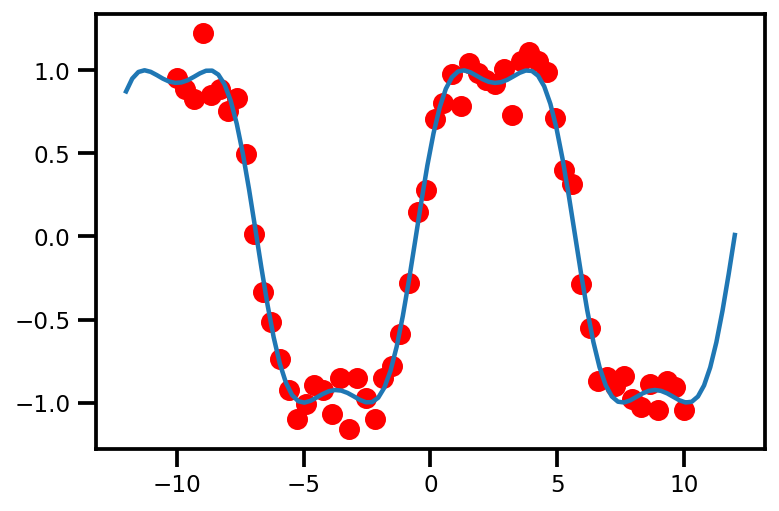

In [3]:
plt.scatter(X, y, color='red')
plt.plot(Xtest, ytest)

## Model

In [4]:
# initialize kernel
kernel = RBF(length_scale=0.01, variance=1.0)

# initialize mean function
# mean = LinearMean(input_dim=1, output_dim=1)
mean = ZeroMean()

# initialize function
gp_model = ExactGP(mean=mean, kernel=kernel)

# inspect variables
for ikey, val in gp_model.vars().items():
    print(ikey, val.value)

(ExactGP).kernel(RBF).variance [1.]
(ExactGP).kernel(RBF).length_scale [0.01]
(ExactGP).noise [0.1]


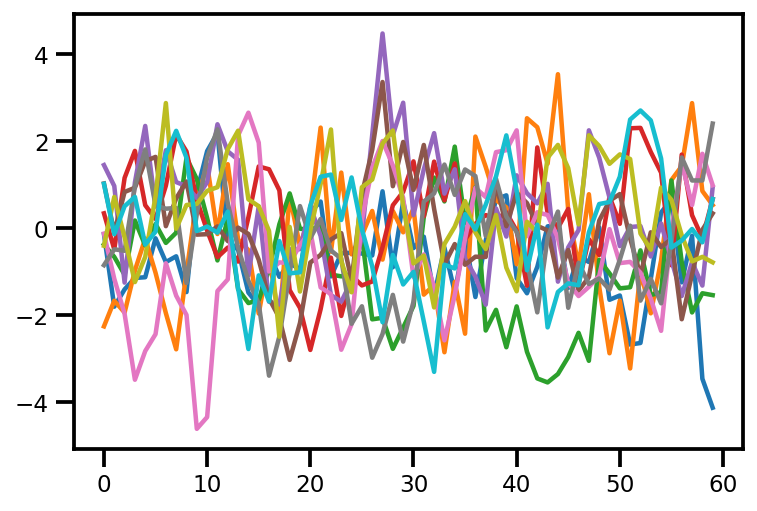

In [5]:
# generate random samples
dist = gp_model.forward(X)

seed = jax.random.PRNGKey(123)
y_samples = dist.sample((10,), seed=seed)

# plot
plt.plot(y_samples.T);

### Training

In [6]:
from jaxkern.gp.optimize import optimize_model

In [7]:
loss_f = jax.partial(negative_log_likelihood, gp_model)
jitted = True
n_epochs = 1_000
lr = 0.01

model, losses = optimize_model(
    model=gp_model,
    loss_f=loss_f,
    X=X, y=y,
    lr=lr,
    opt=objax.optimizer.Adam,
    n_epochs=n_epochs,
    jitted=jitted
)

100%|██████████| 1000/1000 [00:02<00:00, 417.05it/s]


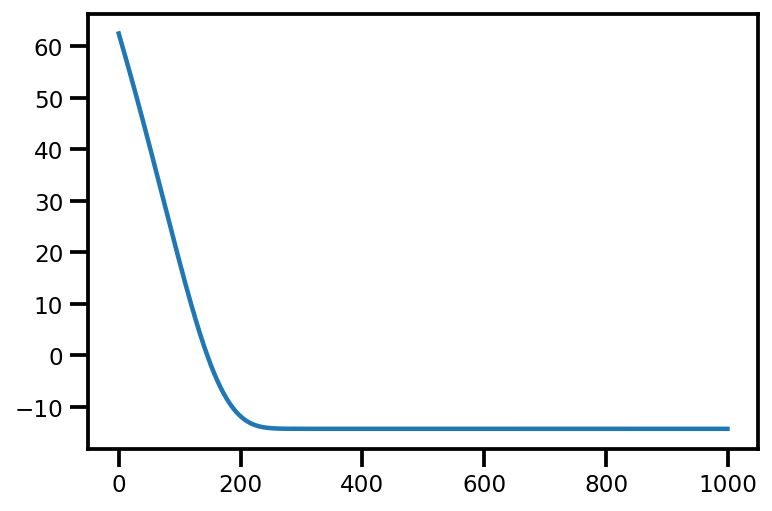

In [8]:
plt.plot(losses)

In [9]:
for ikey, val in model.vars().items():
    print(ikey, val.value, jax.nn.softplus(val.value), type(val.value), val.value.shape)

(ExactGP).kernel(RBF).variance [0.00743297] [0.6968706] <class 'jax.interpreters.xla.DeviceArray'> (1,)
(ExactGP).kernel(RBF).length_scale [1.5743873] [1.7626367] <class 'jax.interpreters.xla.DeviceArray'> (1,)
(ExactGP).noise [-2.1372218] [0.11152542] <class 'jax.interpreters.xla.DeviceArray'> (1,)


In [10]:
model.cache_factorizations(X, y)

mu, cov = model.predict_f(Xtest)
y_var = np.diagonal(cov)
lb, ub = confidence_intervals(mu, y_var, 96)

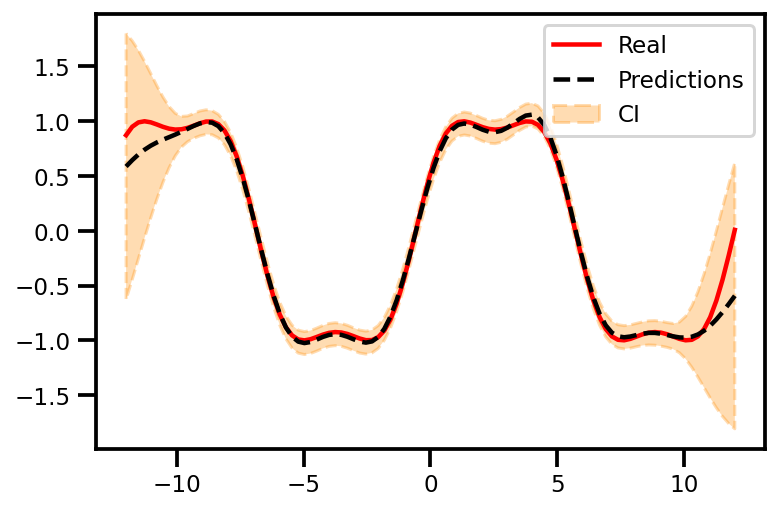

In [11]:
# plot
plt.plot(Xtest, ytest, label='Real', color='red')
plt.plot(Xtest, mu, linestyle="--", label='Predictions', color='black')
plt.fill_between(Xtest.squeeze(), lb, ub, label='CI', color='darkorange', alpha=0.3)

plt.legend()

In [13]:
mu, cov = model.predict_y(Xtest)
y_var = np.diagonal(cov)
lb, ub = confidence_intervals(mu, y_var, 96)

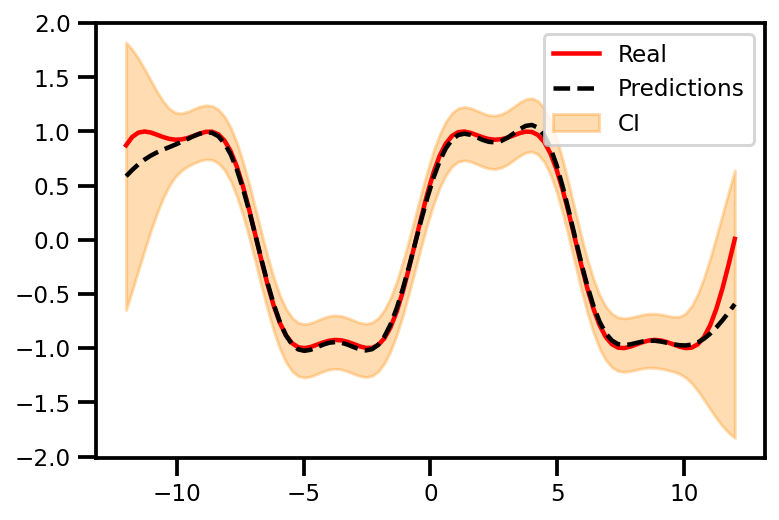

In [14]:
plt.plot(Xtest, ytest, label='Real', color='red')
plt.plot(Xtest, mu, linestyle="--", label='Predictions', color='black')
plt.fill_between(Xtest.squeeze(), lb, ub,label='CI', color='darkorange', alpha=0.3)

plt.legend()